Imports

In [1]:
import pandas as pd
import numpy as np
import random
import scipy
import json
import nltk
import math
import re
import threading
import copy
import requests 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize.regexp import (WordPunctTokenizer,wordpunct_tokenize)

Links for the datasets

In [2]:
url_links = 'https://zrekoj.github.io/hybrid-recommender-system/dataset/links.csv'
url_movies = 'https://zrekoj.github.io/hybrid-recommender-system/dataset/movies.csv'
url_ratings = 'https://zrekoj.github.io/hybrid-recommender-system/dataset/ratings.csv'
url_tags = 'https://zrekoj.github.io/hybrid-recommender-system/dataset/tags.csv'
url_genres = 'https://zrekoj.github.io/hybrid-recommender-system/dataset/user_genre.json'

Datasets

In [3]:
ds_links = pd.read_csv(url_links, dtype = str)
ds_movies = pd.read_csv(url_movies, dtype = str)
ds_ratings = pd.read_csv(url_ratings)
ds_tags = pd.read_csv(url_tags, dtype = str)
ds_user_genres = pd.read_json(url_genres)

In [4]:
list_movies_id = list(ds_movies['movieId'].unique())
list_title_id = ds_movies['title'].tolist()
list_users_id = list(ds_ratings['userId'].unique())
list_movies_imdbid = ds_links['imdbId'].tolist()

Input ratings

In [5]:
'''
movie_ids=[]
ratings=[]

for i in range(10):
  index=random.randint(0,len(list_movies_id)-1)
  while list_movies_id[index] in movie_ids:
    index=random.randint(0,len(list_movies_id)-1)
  rating = float(input('Rate the movie '+str(list_title_id[index])+' from 0.5 to 5.0 or say 0.0 if you haven\'t seen it :'))
  movie_ids.append(list_movies_id[index])
  ratings.append(rating)
print(movie_ids)
print(ratings)
'''


"\nmovie_ids=[]\nratings=[]\n\nfor i in range(10):\n  index=random.randint(0,len(list_movies_id)-1)\n  while list_movies_id[index] in movie_ids:\n    index=random.randint(0,len(list_movies_id)-1)\n  rating = float(input('Rate the movie '+str(list_title_id[index])+' from 0.5 to 5.0 or say 0.0 if you haven't seen it :'))\n  movie_ids.append(list_movies_id[index])\n  ratings.append(rating)\nprint(movie_ids)\nprint(ratings)\n"

Collaborative filtering

SVD

In [6]:
def getGenresByUser(user_id, ds=ds_user_genres):
  return ds[user_id]['like'], ds[user_id]['dislike']
getGenresByUser(616)

(['Thriller', 'Sci-Fi', 'Adventure', 'Comedy'],
 ['War', 'Romance', 'Action', 'IMAX'])

In [7]:
#hyperparams

test_ratio = 0.2 #fraction of data to be used as test set.
no_of_features = [8,10,12,14,17,20] # to test the performance over a different number of features

In [8]:
ds_ratings['userId'] = ds_ratings['userId'].astype('str')
ds_ratings['movieId'] = ds_ratings['movieId'].astype('str')

users = ds_ratings['userId'].unique() #list of all users
movies = ds_ratings['movieId'].unique() #list of all movies

test = pd.DataFrame(columns=ds_ratings.columns)
train = pd.DataFrame(columns=ds_ratings.columns)

for u in users:
  temp = ds_ratings[ds_ratings['userId'] == u]
  n = len(temp)
  test_size = int(test_ratio*n)

  temp = temp.sort_values('timestamp').reset_index()
  temp.drop('index', axis=1, inplace=True)

  dummy_test = temp.loc[n-1-test_size :]
  dummy_train = temp.loc[: n-2-test_size]
    
  test = pd.concat([test, dummy_test])
  train = pd.concat([train, dummy_train])

In [9]:
from scipy.linalg import sqrtm

def create_user_item_matrix(data, formatizer = {'user':0, 'item': 1, 'value': 2}):
    itemField = formatizer['item']
    userField = formatizer['user']
    valueField = formatizer['value']

    
    userList = data.iloc[:,userField].tolist()
    itemList = data.iloc[:,itemField].tolist()
    valueList = data.iloc[:,valueField].tolist()

    users = list(set(data.iloc[:,userField]))
    items = list(set(data.iloc[:,itemField]))

    users_index = {users[i]: i for i in range(len(users))}

    pd_dict = {item: [np.nan for i in range(len(users))] for item in items}

    for i in range(0,len(data)):
      item = itemList[i]
      user = userList[i]
      value = valueList[i]

      pd_dict[item][users_index[user]] = value
    
    X = pd.DataFrame(pd_dict)
    X.index = users

    itemcols = list(X.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}

    # users_index gives us a mapping of user_id to index of user
    # items_index provides the same for items

    return X, users_index, items_index

In [10]:
def svd(ratings, k):
    utilMat = np.array(ratings)

    # the nan or unavailable entries are masked
    mask = np.isnan(utilMat)
    masked_arr = np.ma.masked_array(utilMat, mask)

    item_means = np.mean(masked_arr, axis=0)

    # nan entries will replaced by the average rating for each item
    utilMat = masked_arr.filled(item_means)
    x = np.tile(item_means, (utilMat.shape[0],1))

    # we remove the per item average from all entries.
    # the above mentioned nan entries will be essentially zero now
    utilMat = utilMat - x

    # The magic happens here. U and V are user and item features
    U, s, V=np.linalg.svd(utilMat, full_matrices=False)
    s=np.diag(s)

    # we take only the k most significant features
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]

    s_root=sqrtm(s)
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)
    #UsV = UsV + x
    return UsV

In [11]:
def rmse(true, pred):
    x = true - pred
    return sum([xi*xi for xi in x])/len(x)

In [12]:
uiMat, users_index, items_index = create_user_item_matrix(train)

In [13]:
#svd evaluation
for f in no_of_features:
  svdout = svd(uiMat, k=f)
  pred = [] #to store the predicted ratings
  for _,row in test.iterrows():
    user = row['userId']
    item = row['movieId']
    u_index = users_index[user]
    
    if item in items_index:
      i_index = items_index[item]
      pred_rating = svdout[u_index, i_index]
    else:
      pred_rating = np.mean(svdout[u_index, :])
    pred.append(pred_rating)
  print(rmse(test['rating'], pred))

13.057810960679397
13.052522601872393
13.045372584798518
13.034504338608546
13.033417756750598
13.024659455074687


In [14]:
useritemMat, u_index, i_index = create_user_item_matrix(ds_ratings)
svdout = svd(useritemMat, k=12)

In [15]:
def collaborative_filtering(u_id, svdout=svdout, user_genres = ds_user_genres, movies = ds_movies, u_index=u_index, i_index=i_index):
  user_pos = u_index[str(u_id)]
  u_likes, u_detest = getGenresByUser(u_id)

  result = []
  for i_id in i_index:
    item_pos = i_index[i_id]
    item_row = movies.loc[movies['movieId'] == str(i_id)]
    i_genre = item_row["genres"].tolist()[0].split(sep="|")
    checkDislike =  any(item in i_genre for item in u_detest)
    
    if checkDislike is False:
      new_rate = svdout[user_pos, item_pos]
      checkLike = any(item in i_genre for item in u_likes)
      
      if checkLike is True:
        new_rate = new_rate + new_rate * .3
      else:
        new_rate = new_rate - new_rate * .2
      if (new_rate > 5.0):
        new_rate = 5.0

      result.append([i_id, item_row["title"].tolist()[0], new_rate])
  
  return sorted(result, key=lambda item: item[2], reverse=True)[:20]


**Content-based**

In [16]:
def cosine_similarity(u, v):
    return np.dot(u, np.transpose(v)) / (np.linalg.norm(u) * np.linalg.norm(v))

Calculate TF-IDF

In [17]:
 def computeTFIDF(user_frequence_dict):
        copied = copy.deepcopy(user_frequence_dict)
        total_movies = len(copied)
        total_word_movies_count = {}

        for frequency in copied.values():
            for word in frequency:
                total_word_movies_count[word] = total_word_movies_count.get(word, 0) + 1

        for frequency in copied.values():
            total_words_count = len(frequency)
            for word in frequency:
                #                TF                                 IDF
                frequency[word] = (frequency[word] / total_words_count) * (math.log(1 + (total_movies / total_word_movies_count[word])))
        return copied

Content-Based application

In [24]:
def content_based(user_id, hybrid=True):

    movie_similarities=[]

    #Get imbdIds of user movies
    user_movies = list(
        map(
            lambda movie_id : str(ds_links.loc[ds_links['movieId'] == str(movie_id), 'imdbId'].values[0]), 
            ds_ratings.loc[ds_ratings['userId'] == str(user_id), 'movieId'].tolist()
        )
    )
    
    
    movies=[]

    #If we are using content-based as part of the hybrid filter, it uses the results of the collaborative filtering
    #Otherwise it uses all movies
    if(hybrid):
        collaborative_filtering_result = collaborative_filtering(user_id)
        movies = list(
            map(
                lambda result : ds_links.loc[ds_links['movieId'] == str(result[0]), 'imdbId'].values[0], 
                collaborative_filtering_result
            )
        )
    else:
        movies=[str(movie_id) for movie_id in list_movies_imdbid if movie_id not in user_movies]
    response = requests.get('https://zrekoj.github.io/hybrid-recommender-system/user_frequency/'+ str(user_id)+'.json') 
    user_frequence_dict = response.json()
    i=0
    for movie in movies:
        MaxSim = 0

        movie_frequence_dict = requests.get('https://zrekoj.github.io/hybrid-recommender-system/frequency/'+ str(movie)+'.json').json() 
        user_frequence_dict[str(movie)] = movie_frequence_dict
        TFIDF = computeTFIDF(user_frequence_dict)
        if(movie not in user_movies):
            user_frequence_dict.pop(str(movie), None)

        no_exist_string = "***###***"
        
        TFIDF_highest = TFIDF[str(movie)]
        
        for user_movie in user_movies:
            TFIDF_user =  TFIDF[str(user_movie)]
            
            TFIDF_highest_keys = TFIDF_highest.keys()
            TFIDF_user_keys = TFIDF_user.keys()
            
            coincidence = list(set(TFIDF_highest_keys) & set(TFIDF_user_keys))
            TFIDF_highest_values_diff = list(set(TFIDF_highest_keys) - set(TFIDF_user_keys))
            TFIDF_user_values_diff = list(set(TFIDF_user_keys) - set(TFIDF_highest_keys))
            
            TFIDF_highest_values = coincidence + TFIDF_highest_values_diff + ([no_exist_string] * len(TFIDF_user_values_diff))
            TFIDF_user_values = coincidence + ([no_exist_string] * len(TFIDF_highest_values_diff)) + TFIDF_user_values_diff
            
            TFIDF_highest_values = list(
                map(
                    lambda value : TFIDF_highest[value] if value != no_exist_string else 0,
                    TFIDF_highest_values
                )
            )
            
            TFIDF_user_values = list(
                map(
                    lambda value : TFIDF_user[value] if value != no_exist_string else 0,
                    TFIDF_user_values
                )
            )
            
            similarity = cosine_similarity(TFIDF_highest_values, TFIDF_user_values)        

            if(similarity > MaxSim):
                MaxSim = similarity
        if(hybrid):
            movie_similarities.append([movie, MaxSim,collaborative_filtering_result[i][0],collaborative_filtering_result[i][1],collaborative_filtering_result[i][2]])
            
        else:
            movie_similarities.append([movie, MaxSim])
        i+=1
        

    return sorted(movie_similarities, key=lambda item: item[1], reverse=True)
#content_based(612)


Fuzzy Expert

In [25]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

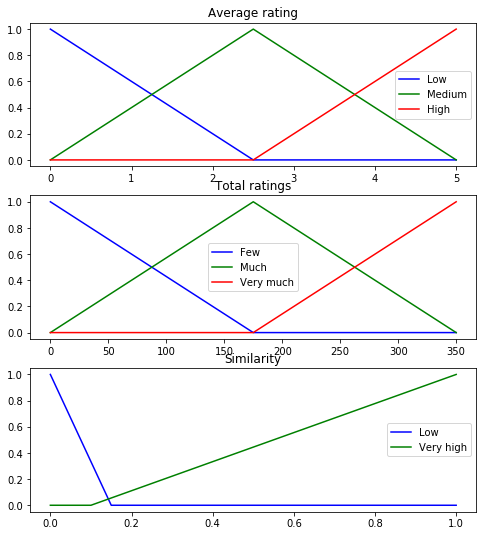

In [26]:
#Not normalized
user_id=1

user_ratings = ds_ratings[ds_ratings['userId']==str(user_id)]
average_rating=np.average(user_ratings['rating'])
total_rating=len(user_ratings['rating'])
content_based_result=[['0102798', 0.17307629401493463], ['0199129', 0.12967858576323765], ['0113824', 0.125902194245651], ['0294357', 0.12049458341852526], ['0112342', 0.09077668893012354], ['0118819', 0.08952145915043483], ['0304229', 0.0855014873973386], ['1094249', 0.07950933188193429], ['1510938', 0.07786330345947903], ['0092545', 0.07533071561265854], ['0041594', 0.07057003329608129], ['2381991', 0.06856206481457755], ['0038499', 0.06793468001299897], ['0146838', 0.06455013019546887], ['0114916', 0.0595944109930006], ['0104779', 0.05918078229511197], ['0089385', 0.05815471304629225], ['0244316', 0.05788941191858764], ['0114007', 0.055105358151090536], ['0119577', 0.03278998241794748]]
#content_based_result=content_based(user_id)
similarity=content_based_result[0][1]
#Generate variables
inp1 = np.arange(0, 5.5, 0.5)
inp2 = np.arange(0, 351, 1)
inp3 = np.arange(0, 1.05, 0.05)
importance = np.arange(0, 1.05, 0.05)

#Generate fuzzy membership functions
inp1_low = fuzz.trimf(inp1, [0, 0, 2.5])
inp1_medium = fuzz.trimf(inp1, [0, 2.5, 5])
inp1_high = fuzz.trimf(inp1, [2.5, 5, 5])
inp2_few = fuzz.trimf(inp2, [0, 0, 175])
inp2_much = fuzz.trimf(inp2, [0, 175, 350])
inp2_very_much = fuzz.trimf(inp2, [175, 350, 350])
inp3_low = fuzz.trimf(inp3, [0, 0, 0.15])
inp3_very_high = fuzz.trimf(inp3, [0.1, 1, 1])
importance_very_low = fuzz.trimf(importance, [0, 0, 0.25])
importance_low = fuzz.trimf(importance, [0, 0.25, 0.5])
importance_medium = fuzz.trimf(importance, [0.25, 0.5, 0.75])
importance_high = fuzz.trimf(importance, [0.5, 0.75, 1])
importance_very_high = fuzz.trimf(importance, [0, 1, 1])

#Visualize fuzzy membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))
ax0.plot(inp1, inp1_low, 'b', linewidth=1.5, label='Low')
ax0.plot(inp1, inp1_medium, 'g', linewidth=1.5, label='Medium')
ax0.plot(inp1, inp1_high, 'r', linewidth=1.5, label='High')
ax0.set_title('Average rating')
ax0.legend()

ax1.plot(inp2, inp2_few, 'b', linewidth=1.5, label='Few')
ax1.plot(inp2, inp2_much, 'g', linewidth=1.5, label='Much')
ax1.plot(inp2, inp2_very_much, 'r', linewidth=1.5, label='Very much')
ax1.set_title('Total ratings')
ax1.legend()

ax2.plot(inp3, inp3_low, 'b', linewidth=1.5, label='Low')
ax2.plot(inp3, inp3_very_high, 'g', linewidth=1.5, label='Very high')
ax2.set_title('Similarity')
ax2.legend()


In [27]:
#Normalized

def fuzzy(user_id):
    content_based_result=content_based(user_id)



    #Generate variables
    inp1 = np.arange(0, 1.01, 0.01)
    inp2 = np.arange(0, 1.01, 0.01)
    inp3 = np.arange(0, 1.01, 0.01)
    importance = np.arange(0, 1.01, 0.01)

    #Generate fuzzy membership functions
    inp1_low = fuzz.trimf(inp1, [0, 0, 0.5])
    inp1_medium = fuzz.trimf(inp1, [0, 0.5, 1])
    inp1_high = fuzz.trimf(inp1, [0.5, 1, 1])
    inp2_few = fuzz.trimf(inp2, [0, 0, 0.3])
    inp2_medium = fuzz.trimf(inp2, [0.2, 0.4, 0.6])
    inp2_much = fuzz.trimf(inp2, [0.4, 0.6, 0.8])
    inp2_very_much = fuzz.trimf(inp2, [0.7, 1, 1])
    inp3_very_low = fuzz.trimf(inp3, [0, 0, 0.06])
    inp3_low = fuzz.trimf(inp3, [0, 0, 0.06])
    inp3_medium = fuzz.trimf(inp3, [0.05, 0.07, 0.09])
    inp3_high = fuzz.trimf(inp3, [0.07, 0.1, 0.13])
    inp3_very_high = fuzz.trimf(inp3, [0.1, 1, 1])

    importance_very_low = fuzz.trimf(inp1, [0, 0, 0.25])
    importance_low = fuzz.trimf(inp1, [0, 0.25, 0.5])
    importance_medium = fuzz.trimf(inp1, [0.25, 0.5, 0.75])
    importance_high = fuzz.trimf(inp1, [0.5, 0.75, 1])
    importance_very_high = fuzz.trimf(inp1, [0.75, 1, 1])

    #Visualize fuzzy membership functions
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))
    ax0.plot(inp1, inp1_low, 'b', linewidth=1.5, label='Low')
    ax0.plot(inp1, inp1_medium, 'g', linewidth=1.5, label='Medium')
    ax0.plot(inp1, inp1_high, 'r', linewidth=1.5, label='High')
    ax0.set_title('Average rating')
    ax0.legend()

    ax1.plot(inp2, inp2_few, 'b', linewidth=1.5, label='Few')
    ax1.plot(inp2, inp2_medium, 'g', linewidth=1.5, label='Medium')
    ax1.plot(inp2, inp2_much, 'r', linewidth=1.5, label='Much')
    ax1.plot(inp2, inp2_very_much, 'b', linewidth=1.5, label='Very much')
    ax1.set_title('Total ratings')
    ax1.legend()

    ax2.plot(inp3, inp3_very_low, 'b', linewidth=1.5, label='Very low')
    ax2.plot(inp3, inp3_low, 'g', linewidth=1.5, label='Low')
    ax2.plot(inp3, inp3_medium, 'r', linewidth=1.5, label='Medium')
    ax2.plot(inp3, inp3_high, 'b', linewidth=1.5, label='High')
    ax2.plot(inp3, inp3_very_high, 'g', linewidth=1.5, label='Very high')
    ax2.set_title('Similarity')
    ax2.legend()
    result=[]
    for i in range(0,len(content_based_result)):
        movie_ratings = ds_ratings[ds_ratings['movieId']==str(content_based_result[i][3])]
        average_rating=np.average(movie_ratings['rating'])/5
        total_rating=len(movie_ratings['rating'])/350
        #Apply rules
        inp1_lo = fuzz.interp_membership(inp1, inp1_low, average_rating)
        inp1_md = fuzz.interp_membership(inp1, inp1_medium, average_rating)
        inp1_hi = fuzz.interp_membership(inp1, inp1_high, average_rating)
        inp2_fe = fuzz.interp_membership(inp2, inp2_few, total_rating)
        inp2_md = fuzz.interp_membership(inp2, inp2_medium, total_rating)
        inp2_mu = fuzz.interp_membership(inp2, inp2_much, total_rating)
        inp2_vm = fuzz.interp_membership(inp2, inp2_very_much, total_rating)
        inp3_lo = fuzz.interp_membership(inp3, inp3_low, content_based_result[i][1])
        inp3_md = fuzz.interp_membership(inp3, inp3_medium, content_based_result[i][1])
        inp3_hi = fuzz.interp_membership(inp3, inp3_high, content_based_result[i][1])
        inp3_vh = fuzz.interp_membership(inp3, inp3_very_high, content_based_result[i][1])

        inp1_low_and_inp2_few = np.fmin(inp1_lo, inp2_fe)
        inp1_low_and_inp2_medium = np.fmin(inp1_lo, inp2_md)
        inp1_low_and_inp2_much = np.fmin(inp1_lo, inp2_mu)
        inp1_low_and_inp2_very_much = np.fmin(inp1_lo, inp2_vm)

        inp1_medium_and_inp2_few = np.fmin(inp1_md, inp2_fe)
        inp1_medium_and_inp2_medium = np.fmin(inp1_md, inp2_md)
        inp1_medium_and_inp2_much = np.fmin(inp1_md, inp2_mu)
        inp1_medium_and_inp2_very_much = np.fmin(inp1_md, inp2_vm)

        inp1_high_and_inp3_low = np.fmin(inp1_hi, inp3_lo)
        inp1_high_and_inp3_med = np.fmin(inp1_hi, inp3_md)
        inp1_high_and_inp3_high = np.fmin(inp1_hi, inp3_hi)
        inp1_high_and_inp3_very_high = np.fmin(inp1_hi, inp3_vh)

        rule_001_005_009 = np.fmin(inp1_low_and_inp2_few, inp3_lo)
        rule_002_006_010 = np.fmin(inp1_low_and_inp2_few, inp3_md)
        rule_003_007_011 = np.fmin(inp1_low_and_inp2_few, inp3_hi)
        rule_004_008_012 = np.fmin(inp1_low_and_inp2_few, inp3_vh)

        rule_013_017_021 = np.fmin(inp1_low_and_inp2_medium, inp3_lo)
        rule_014_018_022 = np.fmin(inp1_low_and_inp2_medium, inp3_md)
        rule_015_019_023 = np.fmin(inp1_low_and_inp2_medium, inp3_hi)
        rule_016_020_024 = np.fmin(inp1_low_and_inp2_medium, inp3_vh)

        rule_025_029_033 = np.fmin(inp1_low_and_inp2_much, inp3_lo)
        rule_026_030_034 = np.fmin(inp1_low_and_inp2_much, inp3_md)
        rule_027_031_035 = np.fmin(inp1_low_and_inp2_much, inp3_hi)
        rule_028_032_036 = np.fmin(inp1_low_and_inp2_much, inp3_vh)

        rule_037_041_045 = np.fmin(inp1_low_and_inp2_very_much, inp3_lo)
        rule_038_042_046 = np.fmin(inp1_low_and_inp2_very_much, inp3_md)
        rule_039_043_047 = np.fmin(inp1_low_and_inp2_very_much, inp3_hi)
        rule_040_044_048 = np.fmin(inp1_low_and_inp2_very_much, inp3_vh)

        rule_049_053_057 = np.fmin(inp1_medium_and_inp2_few, inp3_lo)
        rule_050_054_058 = np.fmin(inp1_medium_and_inp2_few, inp3_md)
        rule_051_055_059 = np.fmin(inp1_medium_and_inp2_few, inp3_hi)
        rule_052_056_060 = np.fmin(inp1_medium_and_inp2_few, inp3_vh)

        rule_061_065_069 = np.fmin(inp1_medium_and_inp2_medium, inp3_lo)
        rule_062_066_070 = np.fmin(inp1_medium_and_inp2_medium, inp3_md)
        rule_063_067_071 = np.fmin(inp1_medium_and_inp2_medium, inp3_hi)
        rule_064_068_072 = np.fmin(inp1_medium_and_inp2_medium, inp3_vh)

        rule_073_077_081 = np.fmin(inp1_medium_and_inp2_much, inp3_lo)
        rule_074_078_082 = np.fmin(inp1_medium_and_inp2_much, inp3_md)
        rule_075_079_083 = np.fmin(inp1_medium_and_inp2_much, inp3_hi)
        rule_076_080_084 = np.fmin(inp1_medium_and_inp2_much, inp3_vh)

        rule_085_089_093 = np.fmin(inp1_medium_and_inp2_very_much, inp3_lo)
        rule_086_090_094 = np.fmin(inp1_medium_and_inp2_very_much, inp3_md)
        rule_087_091_095 = np.fmin(inp1_medium_and_inp2_very_much, inp3_hi)
        rule_088_092_096 = np.fmin(inp1_medium_and_inp2_very_much, inp3_vh)

        rule_097_101_105 = np.fmin(inp1_high_and_inp3_low, inp2_fe)
        rule_098_102_106 = np.fmin(inp1_high_and_inp3_med, inp2_fe)
        rule_099_103_107 = np.fmin(inp1_high_and_inp3_high, inp2_fe)
        rule_100_104_108 = np.fmin(inp1_high_and_inp3_very_high, inp2_fe)

        rule_109_113_117 = np.fmin(inp1_high_and_inp3_low, inp2_md)
        rule_110_114_118 = np.fmin(inp1_high_and_inp3_med, inp2_md)
        rule_111_115_119 = np.fmin(inp1_high_and_inp3_high, inp2_md)
        rule_112_116_120 = np.fmin(inp1_high_and_inp3_very_high, inp2_md)

        rule_121_125_129 = np.fmin(inp1_high_and_inp3_low, inp2_mu)
        rule_122_126_130 = np.fmin(inp1_high_and_inp3_med, inp2_mu)
        rule_123_127_131 = np.fmin(inp1_high_and_inp3_high, inp2_mu)
        rule_124_128_132 = np.fmin(inp1_high_and_inp3_very_high, inp2_mu)

        rule_133_137_141 = np.fmin(inp1_high_and_inp3_low, inp2_vm)
        rule_134_138_142 = np.fmin(inp1_high_and_inp3_med, inp2_vm)
        rule_135_139_143 = np.fmin(inp1_high_and_inp3_high, inp2_vm)
        rule_136_140_144 = np.fmin(inp1_high_and_inp3_very_high, inp2_vm)


        very_low_rules=np.fmax(rule_001_005_009,
                               np.fmax(rule_002_006_010,
                                       np.fmax(rule_003_007_011,
                                               np.fmax(rule_004_008_012, 
                                                       np.fmax(rule_013_017_021 ,
                                                               np.fmax(rule_014_018_022,
                                                                       np.fmax(rule_015_019_023,
                                                                               np.fmax(rule_016_020_024,
                                                                                      np.fmax(rule_025_029_033,
                                                                                             np.fmax(rule_026_030_034,
                                                                                                    np.fmax(rule_027_031_035,
                                                                                                           np.fmax(rule_028_032_036,
                                                                                                                  np.fmax(rule_037_041_045,
                                                                                                                         np.fmax(rule_038_042_046,
                                                                                                                                np.fmax(rule_039_043_047,
                                                                                                                                        np.fmax(rule_040_044_048,
                                                                                                                                               np.fmax(rule_049_053_057 ,
                                                                                                                                                      np.fmax(rule_050_054_058 ,rule_051_055_059 ))))))))))))))))))

        low_rules=np.fmax(rule_004_008_012,
        np.fmax(rule_049_053_057,
        np.fmax(rule_050_054_058 ,
        np.fmax(rule_051_055_059 ,
        np.fmax(rule_052_056_060,
        np.fmax(rule_061_065_069,
        np.fmax(rule_062_066_070,
        np.fmax(rule_063_067_071,
        np.fmax(rule_064_068_072,
        np.fmax(rule_073_077_081,
        np.fmax(rule_074_078_082,
        np.fmax(rule_075_079_083,
        np.fmax(rule_085_089_093,
        np.fmax(rule_086_090_094,
        np.fmax(rule_097_101_105,rule_098_102_106)))))))))))))))

        medium_rules=np.fmax(rule_052_056_060,
                             np.fmax(rule_062_066_070,
                                     np.fmax(rule_063_067_071,
                                             np.fmax(rule_064_068_072,
                                                     np.fmax(rule_073_077_081,
                                                             np.fmax(rule_074_078_082,
                                                                     np.fmax(rule_075_079_083,
                                                                            np.fmax(rule_076_080_084,
                                                                                    np.fmax(rule_085_089_093,
                                                                                            np.fmax(rule_086_090_094, 
                                                                                                    np.fmax(rule_087_091_095,
                                                                                                            np.fmax(rule_088_092_096,
                                                                                                                np.fmax(rule_087_091_095,
                                                                                                                        np.fmax(rule_088_092_096,
                                                                                                                                np.fmax(rule_099_103_107,
                                                                                                                                        np.fmax(rule_100_104_108, 
                                                                                                                                                np.fmax(rule_109_113_117,
                                                                                                                                                    np.fmax(rule_110_114_118,        
                                                                                                                                                        np.fmax(rule_111_115_119, 
                                                                                                                                                        np.fmax(rule_112_116_120,  
                                                                                                                                                        np.fmax(rule_121_125_129,   
                                                                                                                                                        np.fmax(rule_122_126_130,   
                                                                                                                                                        np.fmax(rule_123_127_131, rule_133_137_141)))))))))))))))))))))))


        high_rules = np.fmax(rule_100_104_108,
                            np.fmax(rule_111_115_119, 
                                   np.fmax(rule_112_116_120, 
                                          np.fmax(rule_122_126_130, 
                                                 np.fmax(rule_123_127_131, 
                                                        np.fmax(rule_124_128_132, 
                                                               np.fmax(rule_133_137_141, 
                                                                      np.fmax(rule_134_138_142, 
                                                                             np.fmax(rule_135_139_143, rule_136_140_144)))))))))
        very_high_rules = np.fmax(rule_124_128_132, np.fmax(rule_135_139_143, rule_136_140_144))

        importance_activation_very_low = np.fmin(very_low_rules,importance_very_low)
        importance_activation_low = np.fmin(low_rules,importance_low)
        importance_activation_medium = np.fmin(medium_rules, importance_medium)
        importance_activation_high = np.fmin(high_rules, importance_high)
        importance_activation_very_high = np.fmin(very_high_rules, importance_very_high)
        importance0 = np.zeros_like(importance)

        fig, ax0 = plt.subplots(figsize=(8, 3))

        ax0.fill_between(importance, importance0, importance_activation_very_low, facecolor='b', alpha=0.7)
        ax0.plot(importance, importance_very_low, 'b', linewidth=0.5, linestyle='--', )
        ax0.fill_between(importance, importance0, importance_activation_low, facecolor='g', alpha=0.7)
        ax0.plot(importance, importance_low, 'g', linewidth=0.5, linestyle='--')
        ax0.fill_between(importance, importance0, importance_activation_medium, facecolor='r', alpha=0.7)
        ax0.plot(importance, importance_medium, 'r', linewidth=0.5, linestyle='--')
        ax0.fill_between(importance, importance0, importance_activation_high, facecolor='b', alpha=0.7)
        ax0.plot(importance, importance_high, 'b', linewidth=0.5, linestyle='--', )
        ax0.fill_between(importance, importance0, importance_activation_very_high, facecolor='g', alpha=0.7)
        ax0.plot(importance, importance_very_high, 'g', linewidth=0.5, linestyle='--')
        ax0.set_title('Output membership activity for '+content_based_result[i][3])

        #Defuzzification
        aggregated = np.fmax(importance_activation_very_low,np.fmax(importance_activation_low, np.fmax(importance_activation_medium,np.fmax(importance_activation_high, importance_activation_very_high))))
        importance_defuzz = fuzz.defuzz(importance, aggregated, 'centroid')
        importance_activation = fuzz.interp_membership(importance, aggregated, importance_defuzz)  # for plot
        if(content_based_result[i][4]<=0):
            result.append([content_based_result[i][2],content_based_result[i][3],content_based_result[i][4]*importance_defuzz])
        else:
            result.append([content_based_result[i][2],content_based_result[i][3],content_based_result[i][4]*(1+importance_defuzz)])

        # Visualize this

        fig, ax0 = plt.subplots(figsize=(8, 3))

        ax0.plot(importance, importance_very_low, 'b', linewidth=0.5, linestyle='--', )
        ax0.plot(importance, importance_low, 'g', linewidth=0.5, linestyle='--')
        ax0.plot(importance, importance_medium, 'r', linewidth=0.5, linestyle='--')
        ax0.plot(importance, importance_high, 'b', linewidth=0.5, linestyle='--')
        ax0.plot(importance, importance_very_high, 'g', linewidth=0.5, linestyle='--')
        ax0.fill_between(importance, importance0, aggregated, facecolor='Orange', alpha=0.7)
        ax0.plot([importance_defuzz, importance_defuzz], [0, importance_activation], 'k', linewidth=1.5, alpha=0.9)
        ax0.set_title('Aggregated membership and result (line) for '+content_based_result[i][3])
    sorted(result, key=lambda item: item[2], reverse=True)
    return result


In [28]:
def writeFormat(user_id, result):
    x = list(map(lambda line : str(user_id) + " & " + " & ".join(list(map(lambda elem : str(elem), line))) + " \\\\\n", result))
    return "".join(x)

611 & 4993 & Lord of the Rings: The Fellowship of the Ring, The (2001) & 0.07224537324999189 \\
611 & 5952 & Lord of the Rings: The Two Towers, The (2002) & 0.06722649408638023 \\
611 & 1196 & Star Wars: Episode V - The Empire Strikes Back (1980) & 0.06432747014827553 \\
611 & 5349 & Spider-Man (2002) & 0.0639861271687373 \\
611 & 7153 & Lord of the Rings: The Return of the King, The (2003) & 0.060994406677498905 \\
611 & 1198 & Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) & 0.05632343125244231 \\
611 & 260 & Star Wars: Episode IV - A New Hope (1977) & 0.05137301569330367 \\
611 & 1580 & Men in Black (a.k.a. MIB) (1997) & 0.050840856254915114 \\
611 & 3793 & X-Men (2000) & 0.04708523497779568 \\
611 & 72998 & Avatar (2009) & 0.045572434459530714 \\
611 & 2571 & Matrix, The (1999) & 0.045544886821725764 \\
611 & 6333 & X2: X-Men United (2003) & 0.04167939948925355 \\
611 & 1210 & Star Wars: Episode VI - Return of the Jedi (1983) & 0.04139220916366015 \\

c:\users\zihao\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\zihao\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\zihao\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


611 & 5349 & Spider-Man (2002) & 0.09331077636768877 \\
611 & 1580 & Men in Black (a.k.a. MIB) (1997) & 0.06806693181389158 \\
611 & 59315 & Iron Man (2008) & 0.050080155419470175 \\
611 & 79132 & Inception (2010) & 0.05026096201122292 \\
611 & 780 & Independence Day (a.k.a. ID4) (1996) & 0.046211848280558014 \\
611 & 72998 & Avatar (2009) & 0.0561908271651059 \\
611 & 1291 & Indiana Jones and the Last Crusade (1989) & 0.04688763423723701 \\
611 & 7153 & Lord of the Rings: The Return of the King, The (2003) & 0.07569908189787458 \\
611 & 5952 & Lord of the Rings: The Two Towers, The (2002) & 0.08337114893891674 \\
611 & 2571 & Matrix, The (1999) & 0.05641009580241658 \\
611 & 4993 & Lord of the Rings: The Fellowship of the Ring, The (2001) & 0.08945644083917118 \\
611 & 3793 & X-Men (2000) & 0.05813587718527025 \\
611 & 6539 & Pirates of the Caribbean: The Curse of the Black Pearl (2003) & 0.05098443277281183 \\
611 & 2628 & Star Wars: Episode I - The Phantom Menace (1999) & 0.04494996

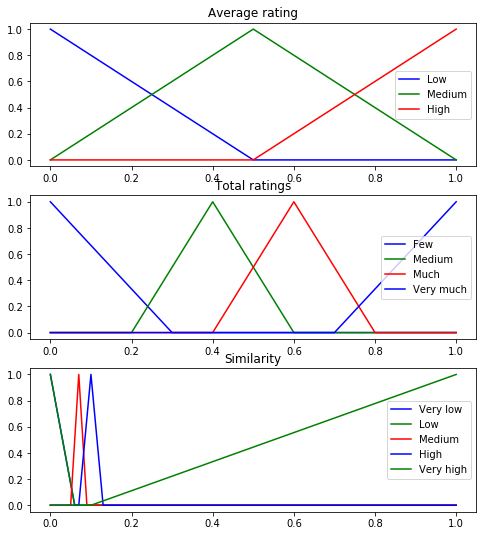

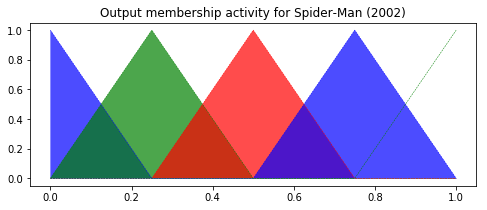

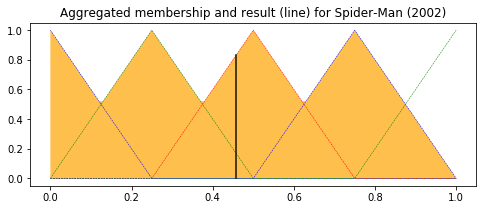

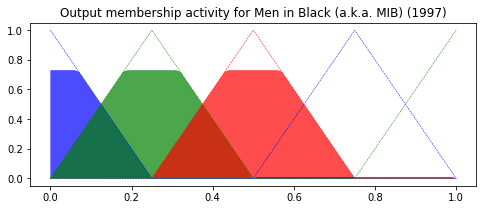

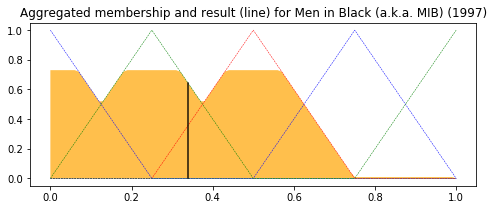

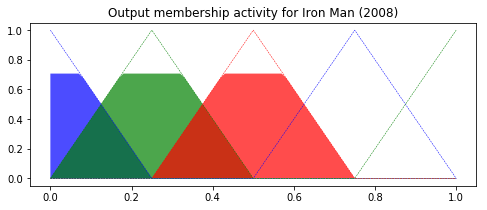

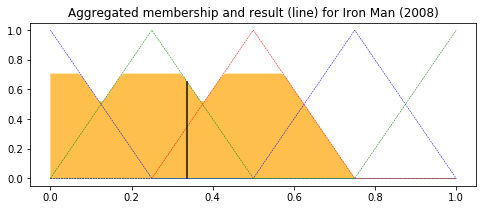

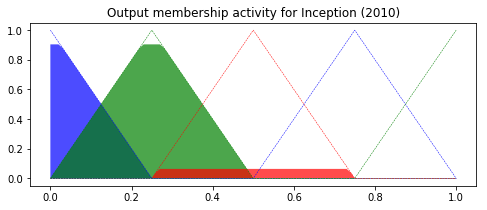

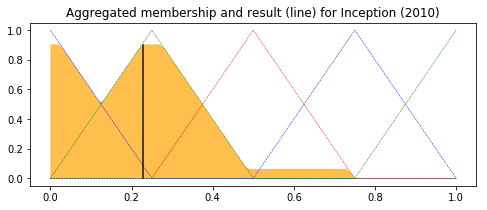

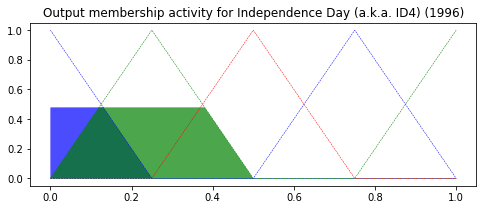

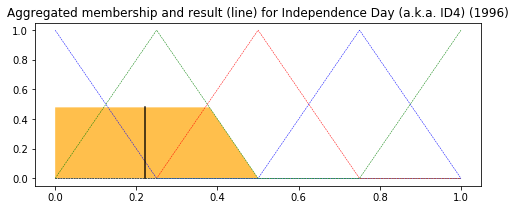

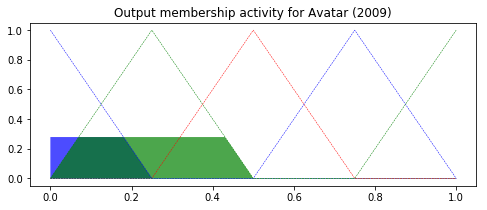

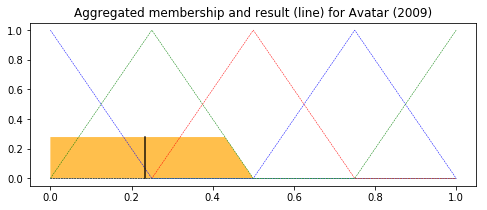

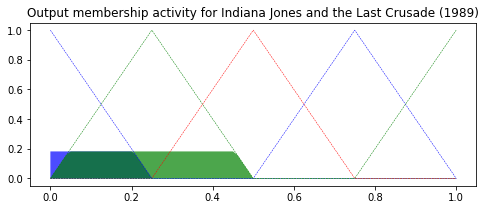

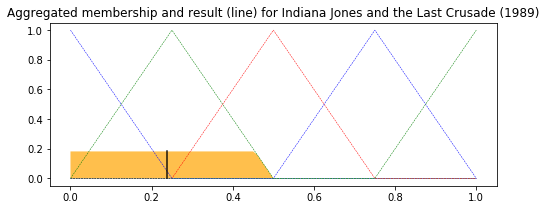

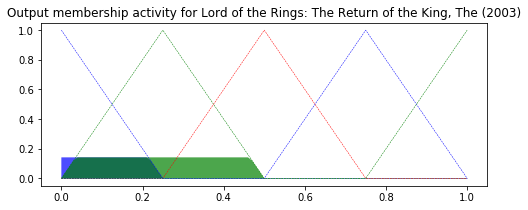

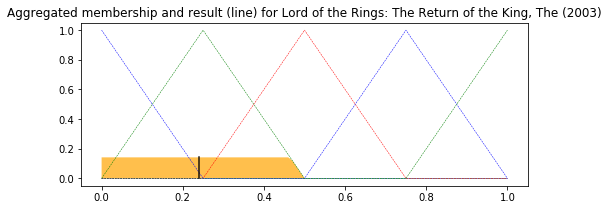

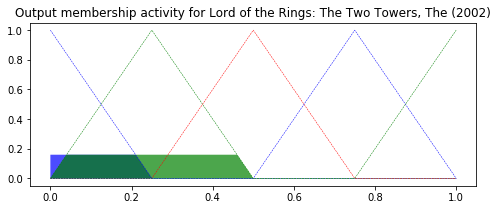

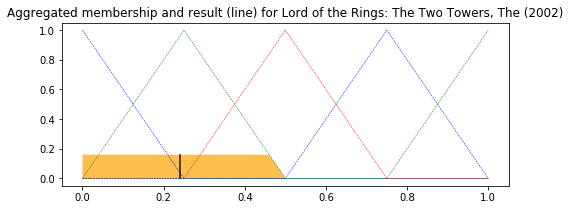

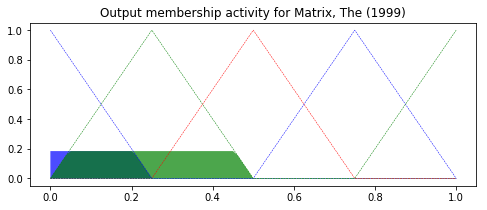

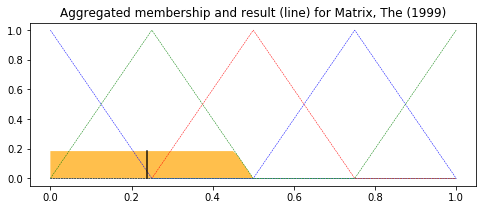

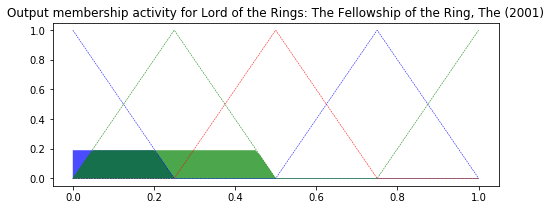

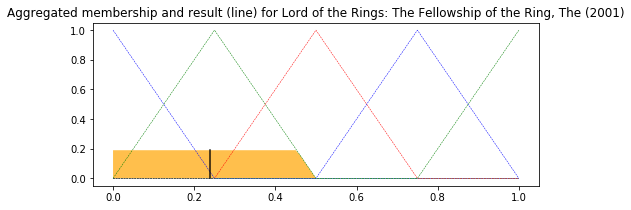

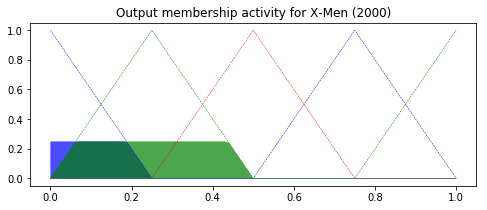

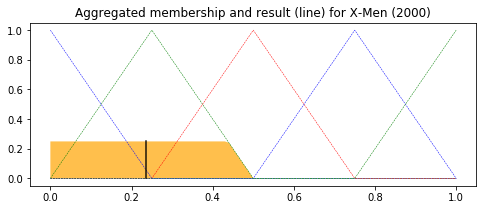

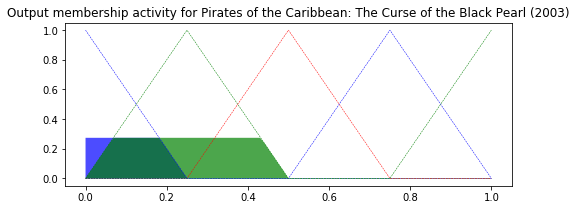

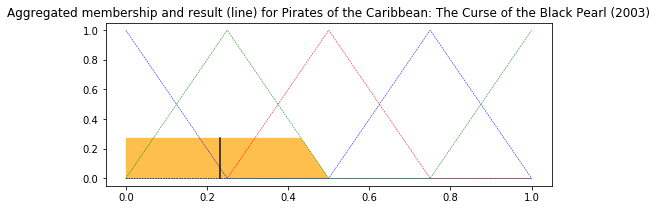

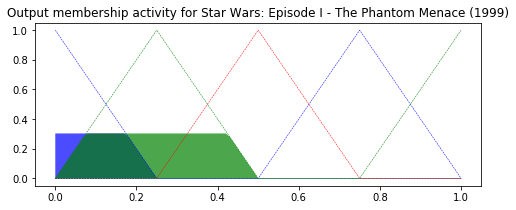

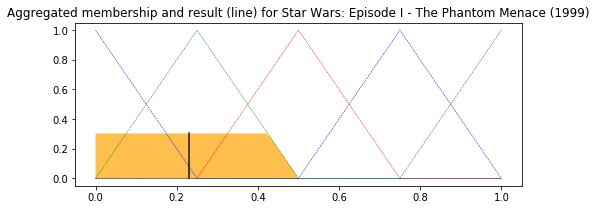

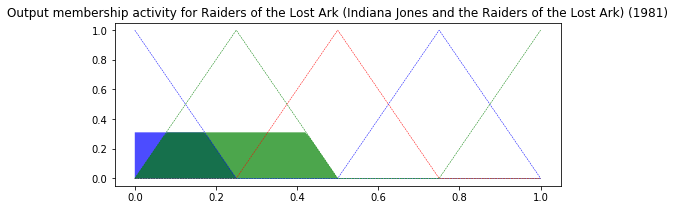

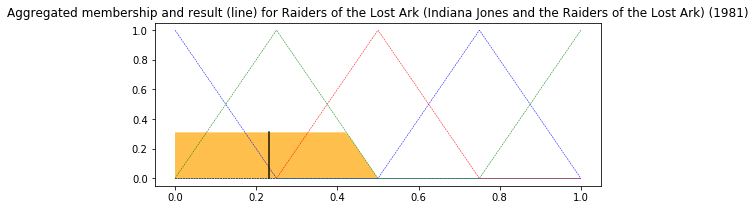

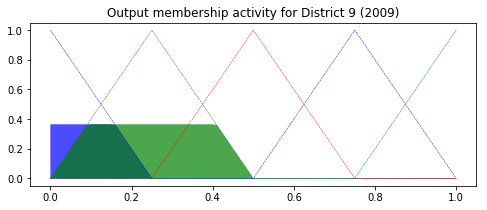

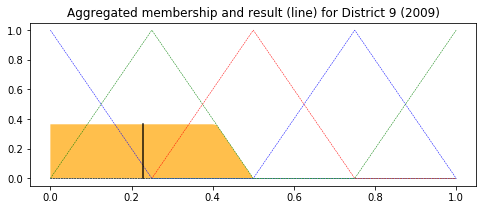

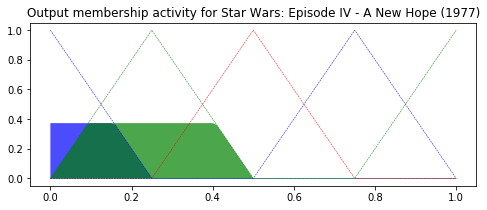

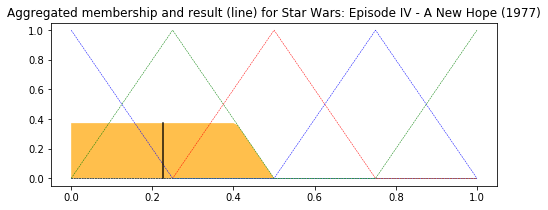

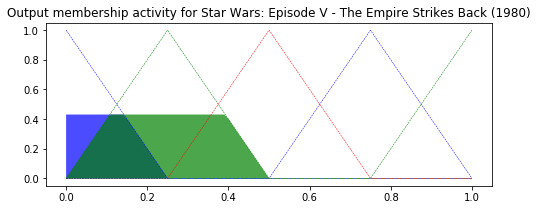

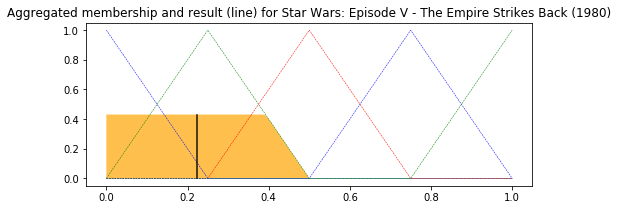

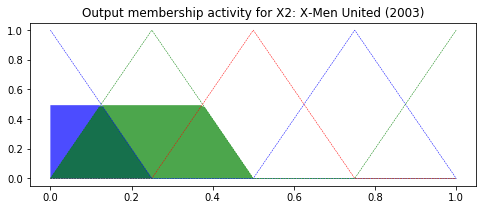

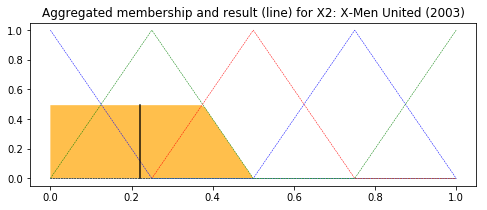

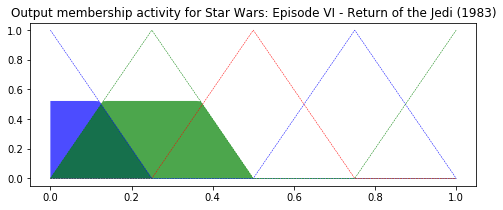

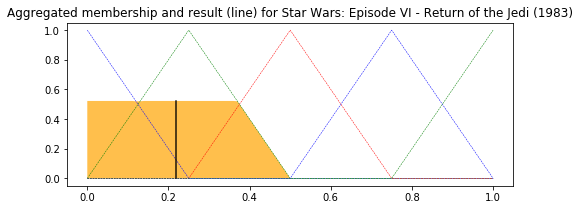

In [29]:
user_id = 611

print(writeFormat(user_id, collaborative_filtering(user_id)))
print("--------------------------------------")
#print(writeFormat(user_id, content_based(user_id, False)))
print("--------------------------------------")
print(writeFormat(user_id, content_based(user_id, True)))
print("--------------------------------------")
print(writeFormat(user_id, fuzzy(user_id)))